In [1]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn import Executor
from squlearn.encoding_circuits import ChebRx
from squlearn.expectation_operator import IsingHamiltonian
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import SLSQP

In [2]:
executor = Executor("statevector_simulator")

Define parameterized quantum circuit $Q(x,\theta)$

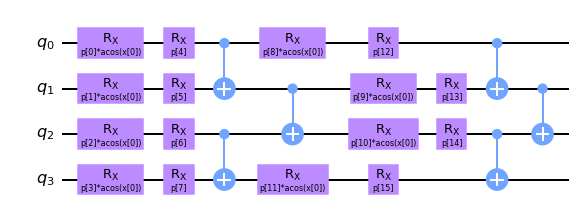

In [3]:
nqubits = 4

number_of_layers = 2
pqc = ChebRx(nqubits, 1, num_layers=number_of_layers)
pqc.draw()

Definition of the cost operator:
$\hat{H} = J \sum\limits_{i < j} Z_i Z_j + h\sum\limits_i Z_i + c$

In [4]:
ising_op = IsingHamiltonian(nqubits, I="S", Z="S", ZZ="S")
print(ising_op)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'IZZI', 'ZIIZ', 'ZIZI', 'ZZII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[1]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[1]), ParameterExpression(1.0*p[2]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[2]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[2]),
 ParameterExpression(1.0*p[2])])


Example function: $log(x)$

In [5]:
x_space = np.arange(0.1, 0.9, 0.1)
ref_values = np.log(x_space)

np.random.seed(13)
param_ini = np.random.rand(pqc.num_parameters)
param_op_ini = np.random.rand(ising_op.num_parameters)

reg = QNNRegressor(pqc, ising_op, executor, SquaredLoss(), SLSQP(), param_ini, param_op_ini)

Optimization of the regression

In [6]:
reg.fit(x_space, ref_values)

theta [0.77770241 0.23754122 0.82427853 0.9657492  0.97260111 0.45344925
 0.60904246 0.77552651 0.64161334 0.72201823 0.03503652 0.29844947
 0.05851249 0.85706094 0.37285403 0.67984795 0.25627995 0.34758122
 0.00941277]
Current value: 15.064846438837378
theta [0.77770241 0.23754122 0.82427853 0.9657492  0.97260111 0.45344925
 0.60904246 0.77552651 0.64161334 0.72201823 0.03503652 0.29844947
 0.05851249 0.85706094 0.37285403 0.67984795 0.25627995 0.34758122
 0.00941277]
Grad length: 23.534559613237978
grad [ -0.05716598  -1.1969308   -2.5070993   -0.15684358  -0.26523052
  -0.92167099  -1.99965822  -0.11460244   3.47621286  -3.85943808
  -1.36884346  -0.15684358   2.57708562  -3.34091146  -0.90915976
  -0.11460244  19.64618798  -1.28281638 -10.29850044]
theta [  0.83486839   1.43447202   3.33137783   1.12259278   1.23783164
   1.37512023   2.60870069   0.89012895  -2.83459952   4.58145631
   1.40387998   0.45529305  -2.51857313   4.1979724    1.28201379
   0.79445039 -19.38990803   1.63

In [7]:
print("Result Param:", reg.param)
print("Result ParamOp:", reg.param_op)

Result Param: [ 0.91858145 -1.1163345   0.38467092  1.39597102  1.10224011  2.41369111
  1.64968778 -0.81903595  0.4867727   0.38505193  1.10635672  0.72867129
 -1.74881862 -0.64411871  0.86344117 -0.91471452]
Result ParamOp: [-0.47157523  5.10755673  2.63075629]


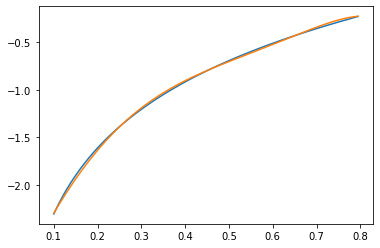

In [8]:
x = np.arange(np.min(x_space), np.max(x_space), 0.005)
y = reg.predict(x)
plt.plot(x, np.log(x))
plt.plot(x, y)

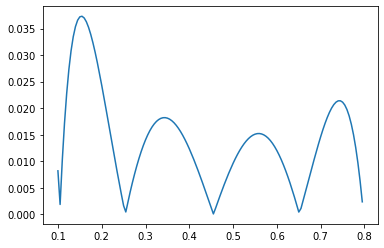

In [9]:
plt.plot(x, np.abs(y - np.log(x)))

C:\Users\DKR\Documents\Git Repositories\squlearn_fork\squlearn\src\squlearn\qnn\qnnr.py:133: UserWarning: The model is not fitted.
  warn("The model is not fitted.")


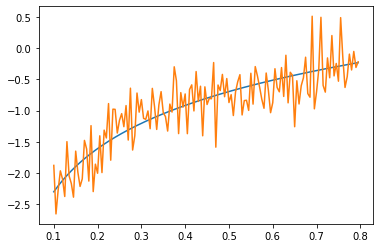

In [10]:
qasm = Executor("qasm_simulator")
qnn_qasm = QNNRegressor(pqc, ising_op, qasm, SquaredLoss, SLSQP(), reg.param, reg.param_op)
y = qnn_qasm.predict(x)
plt.plot(x, np.log(x))
plt.plot(x, y)

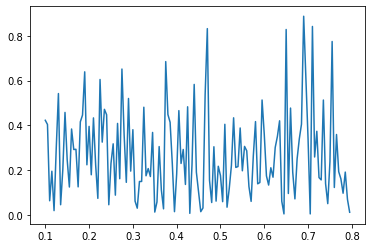

In [11]:
plt.plot(x, np.abs(y - np.log(x)))